In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from IPython.display import Image
import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score

#!pip install -q git+https://github.com/tensorflow/docs 
#import tensorflow_docs as tfdocs
#import tensorflow_docs.modeling
#import tensorflow_docs.plots

Carga del dataset y Análisis exploratorio de los datos

In [ ]:
#path ='/content/drive/MyDrive/Ayudantia 6/data/higgs_small_dataset.csv'
path = '/content/drive/MyDrive/parkinsons.data'
csv = pd.read_csv(path, low_memory=False).replace('?', np.nan).dropna()
#gz = tf.keras.utils.get_file('HIGGS.csv.gz', 'http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz')

In [ ]:
columns = list(set(csv.columns) - set(['name']))

columns = list(set(columns)-set(['status']))
columns.insert(0, 'status')
print(columns)
csv = csv[columns]
csv = csv.astype(np.float)
csv.head()

['status', 'Shimmer:DDA', 'D2', 'MDVP:Fhi(Hz)', 'MDVP:Fo(Hz)', 'MDVP:Flo(Hz)', 'MDVP:PPQ', 'MDVP:Shimmer(dB)', 'HNR', 'spread2', 'PPE', 'Shimmer:APQ3', 'MDVP:Jitter(Abs)', 'Shimmer:APQ5', 'Jitter:DDP', 'MDVP:RAP', 'MDVP:Jitter(%)', 'NHR', 'spread1', 'MDVP:Shimmer', 'DFA', 'RPDE', 'MDVP:APQ']


,status,Shimmer:DDA,D2,MDVP:Fhi(Hz),MDVP:Fo(Hz),MDVP:Flo(Hz),MDVP:PPQ,MDVP:Shimmer(dB),HNR,spread2,PPE,Shimmer:APQ3,MDVP:Jitter(Abs),Shimmer:APQ5,Jitter:DDP,MDVP:RAP,MDVP:Jitter(%),NHR,spread1,MDVP:Shimmer,DFA,RPDE,MDVP:APQ
0,1.0,0.06545,2.301442,157.302,119.992,74.997,0.00554,0.426,21.033,0.266482,0.284654,0.02182,0.00007,0.03130,0.01109,0.00370,0.00784,0.02211,-4.813031,0.04374,0.815285,0.414783,0.02971
1,1.0,0.09403,2.486855,148.650,122.400,113.819,0.00696,0.626,19.085,0.335590,0.368674,0.03134,0.00008,0.04518,0.01394,0.00465,0.00968,0.01929,-4.075192,0.06134,0.819521,0.458359,0.04368
2,1.0,0.08270,2.342259,131.111,116.682,111.555,0.00781,0.482,20.651,0.311173,0.332634,0.02757,0.00009,0.03858,0.01633,0.00544,0.01050,0.01309,-4.443179,0.05233,0.825288,0.429895,0.03590
3,1.0,0.08771,2.405554,137.871,116.676,111.366,0.00698,0.517,20.644,0.334147,0.368975,0.02924,0.00009,0.04005,0.01505,0.00502,0.00997,0.01353,-4.117501,0.05492,0.819235,0.434969,0.03772
4,1.0,0.10470,2.332180,141.781,116.014,110.655,0.00908,0.584,19.649,0.234513,0.410335,0.03490,0.00011,0.04825,0.01966,0.00655,0.01284,0.01767,-3.747787,0.06425,0.823484,0.417356,0.04465


In [ ]:
len(csv)

195

In [ ]:
csv.groupby(['status']).size()

status
0.0     48
1.0    147
dtype: int64

In [ ]:
#Función utilizada para graficar las distribuciones de las variables explicativas
def graficar_distribuciones(csv, columnss, nrowss, ncolss):
  
    fig, axes = plt.subplots(nrows=nrowss, ncols=ncolss , figsize=(15,15))
    axes = axes.flat

    cont = 0
    for i, colum in enumerate(columnss):
        a = i
        if i >= 20:
              a = cont
              cont += 1

        sns.histplot(
            data    = csv,
            x       = colum,
            stat    = "count",
            kde     = True,
            color   = (list(plt.rcParams['axes.prop_cycle'])*2)[a]["color"],
            line_kws= {'linewidth': 2},
            alpha   = 0.3,
            ax      = axes[i]
        )

        axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
        axes[i].tick_params(labelsize = 6)
        axes[i].set_xlabel("")
    
    
    fig.tight_layout()
    plt.subplots_adjust(top = 0.9)
    fig.suptitle('Distribución variables ', fontsize = 10, fontweight = "bold");

Balance Dataset

status
0.0    48
1.0    48
dtype: int64
['Shimmer:DDA', 'D2', 'MDVP:Fhi(Hz)', 'MDVP:Fo(Hz)', 'MDVP:Flo(Hz)', 'MDVP:PPQ', 'MDVP:Shimmer(dB)', 'HNR', 'spread2', 'PPE', 'Shimmer:APQ3', 'MDVP:Jitter(Abs)', 'Shimmer:APQ5', 'Jitter:DDP', 'MDVP:RAP', 'MDVP:Jitter(%)', 'NHR', 'spread1', 'MDVP:Shimmer', 'DFA', 'RPDE', 'MDVP:APQ']
22


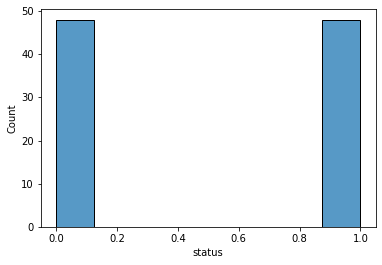

In [ ]:
csv_balanced = pd.concat([csv[csv['status'] == 0].sample(48), 
                              csv[csv['status'] == 1].sample(48)])
print(csv_balanced.groupby(['status']).size())
#csv_balanced.head()
original_features = list(set(csv_balanced.columns)-set(['status']))
print(original_features)
print(len(original_features))
sns.histplot(data = csv_balanced['status'])

In [ ]:
csv_balanced.describe()

,status,Shimmer:DDA,D2,MDVP:Fhi(Hz),MDVP:Fo(Hz),MDVP:Flo(Hz),MDVP:PPQ,MDVP:Shimmer(dB),HNR,spread2,PPE,Shimmer:APQ3,MDVP:Jitter(Abs),Shimmer:APQ5,Jitter:DDP,MDVP:RAP,MDVP:Jitter(%),NHR,spread1,MDVP:Shimmer,DFA,RPDE,MDVP:APQ
count,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000,96.000000
mean,0.500000,0.042666,2.287274,208.796000,161.896010,125.355219,0.003180,0.251698,22.591396,0.202837,0.186220,0.014221,0.000039,0.016001,0.009051,0.003017,0.005741,0.021301,-5.952531,0.026686,0.713507,0.485214,0.021351
std,0.502625,0.028612,0.361152,101.251122,47.444389,51.031525,0.002735,0.182233,4.340640,0.083982,0.094143,0.009537,0.000032,0.011244,0.008438,0.002813,0.004690,0.037454,1.166440,0.017816,0.055448,0.105738,0.016886
min,0.000000,0.014030,1.423287,108.664000,95.056000,65.750000,0.001060,0.085000,8.441000,0.006274,0.044539,0.004680,0.000007,0.006060,0.002760,0.000920,0.001780,0.000650,-7.964984,0.009540,0.605417,0.256570,0.007190
25%,0.000000,0.024343,2.038111,134.016750,117.170500,89.324250,0.001687,0.140000,19.479750,0.154650,0.113666,0.008115,0.000020,0.009447,0.004600,0.001535,0.003018,0.004775,-6.847206,0.015723,0.664239,0.407668,0.012337
50%,0.500000,0.035625,2.272559,200.279500,147.494000,106.922500,0.002375,0.197500,23.153500,0.193501,0.166906,0.011875,0.000030,0.012210,0.006385,0.002125,0.004550,0.009325,-6.110432,0.021050,0.721496,0.464375,0.016720
75%,1.000000,0.050175,2.479485,240.931000,201.541500,152.538750,0.003855,0.289000,25.431250,0.257728,0.231922,0.016725,0.000050,0.018105,0.011097,0.003703,0.006940,0.021923,-5.328554,0.032047,0.760584,0.582187,0.025320
max,1.000000,0.169420,3.274865,592.030000,260.105000,239.170000,0.019580,1.302000,33.047000,0.450493,0.527367,0.056470,0.000220,0.079400,0.055630,0.018540,0.031070,0.259300,-2.434031,0.119080,0.825069,0.677131,0.137780


Descripción variables independientes

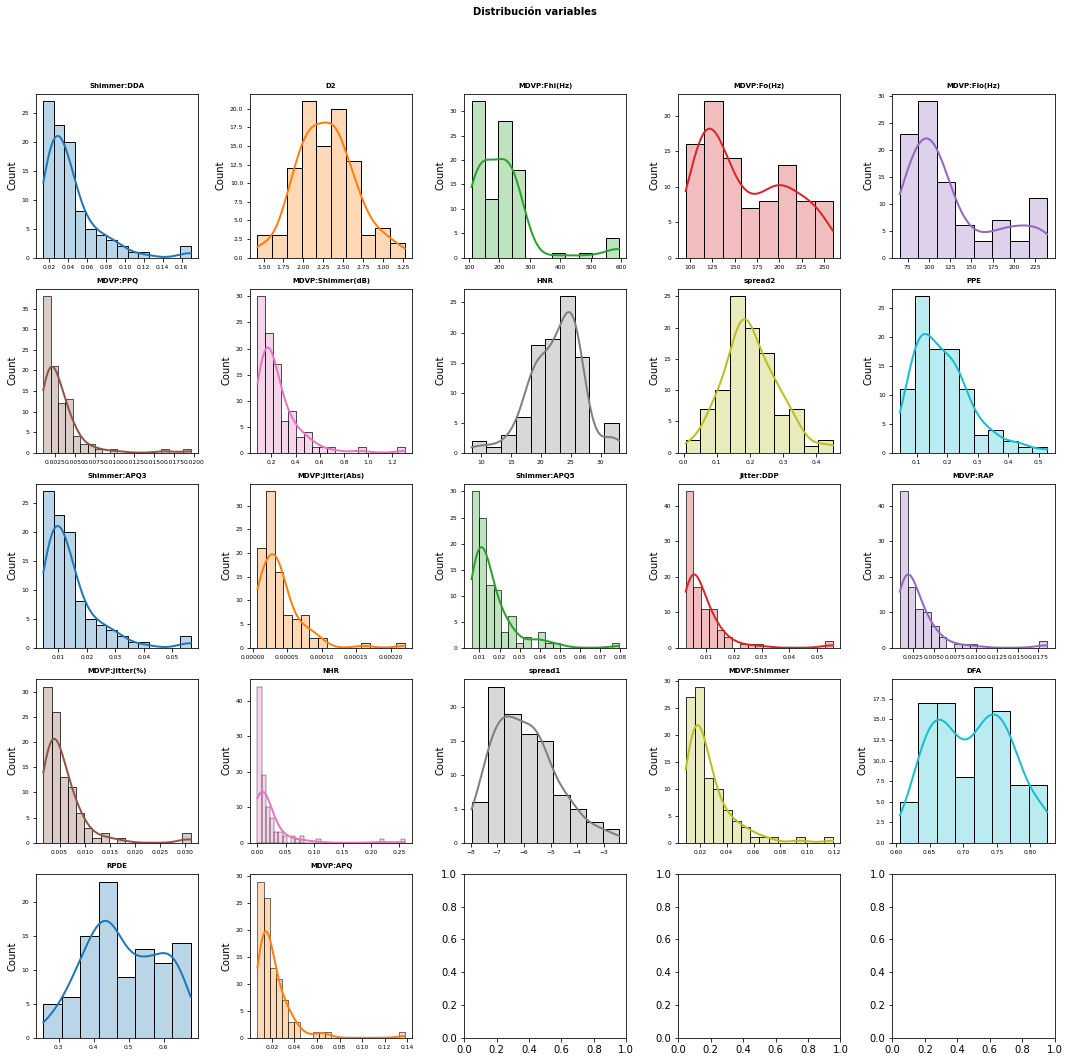

In [ ]:
graficar_distribuciones(csv_balanced[columns[1:]], columns[1:], nrowss= 5, ncolss = 5)

Correlación entre variables independientes

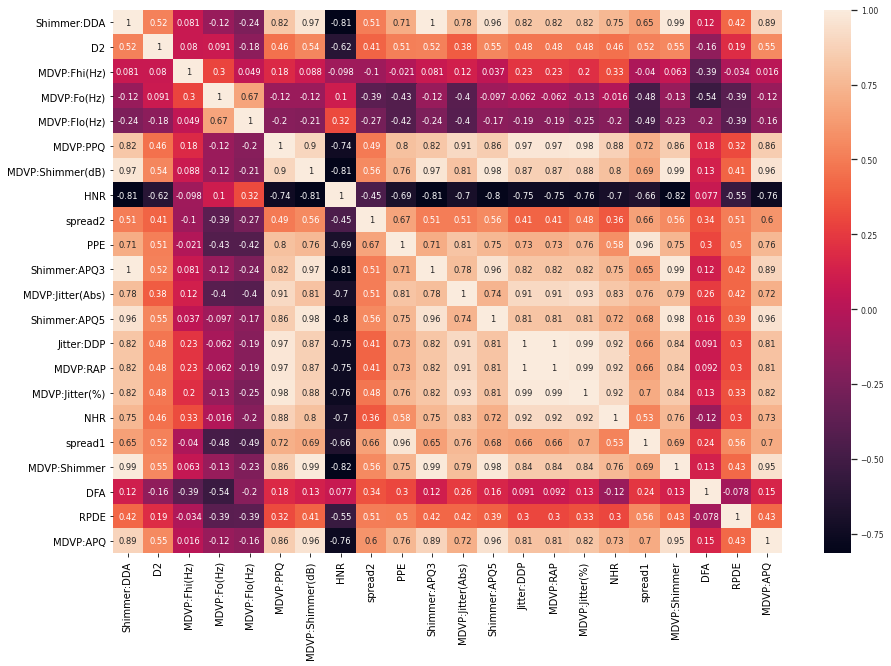

In [ ]:
corr = csv_balanced.corr()
fig, axes = plt.subplots(figsize=(15,10))
sns.set(font_scale=0.7)
corr1 = csv_balanced[columns[1:]].corr()
heat_map = sns.heatmap(corr1, annot= True)

    

Correlación entre variables dependientes con variable independiente

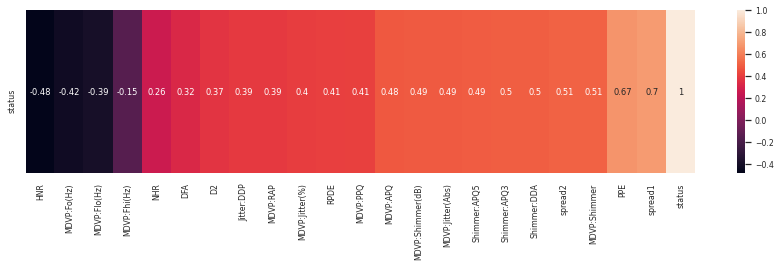

In [ ]:
fig, axes = plt.subplots(figsize=(15,3))
sns.set(font_scale=0.7)
y_corr = corr[['status']].sort_values('status')
heat_map = sns.heatmap(y_corr.T, annot= True)


In [ ]:
features = list(set(columns)-set(['status']))
X = csv_balanced[features]
y = csv_balanced[['status']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = True)
X_train_s = (X_train - X_train.mean())/X_train.std()
X_test_s = (X_test - X_test.mean())/X_test.std()
len(X_train_s)

76

In [ ]:
y_test.groupby(['status']).size()

status
0.0    10
1.0    10
dtype: int64

In [ ]:
new_features = y_corr.T.columns
new_features

Index(['HNR', 'MDVP:Fo(Hz)', 'MDVP:Flo(Hz)', 'MDVP:Fhi(Hz)', 'NHR', 'DFA',
       'D2', 'Jitter:DDP', 'MDVP:RAP', 'MDVP:Jitter(%)', 'RPDE', 'MDVP:PPQ',
       'MDVP:APQ', 'MDVP:Shimmer(dB)', 'MDVP:Jitter(Abs)', 'Shimmer:APQ5',
       'Shimmer:APQ3', 'Shimmer:DDA', 'spread2', 'MDVP:Shimmer', 'PPE',
       'spread1', 'status'],
      dtype='object')

In [ ]:
#Alternativa : Eliminar variables con correlaciones bajas con respecto al target, en este caso, se descartan del modelo las que tengan un valor menor < 0.3.
new_features = new_features[5:-1]
print(new_features)
X_train_s, X_test_s = X_train_s[new_features] , X_test_s[new_features]


Index(['DFA', 'D2', 'Jitter:DDP', 'MDVP:RAP', 'MDVP:Jitter(%)', 'RPDE',
       'MDVP:PPQ', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'MDVP:Jitter(Abs)',
       'Shimmer:APQ5', 'Shimmer:APQ3', 'Shimmer:DDA', 'spread2',
       'MDVP:Shimmer', 'PPE', 'spread1'],
      dtype='object')


In [ ]:
#Alternativa: Reducción dimensionalidad con PCA , el criterio será preservar más del 95% de la variabilidad de los datos, y eso se consigue con mínimo 6 nuevas componentes (n=6)
# Una alternativa que por simplicidad no se realizó, es realizar PCA pero a las variables por separado, es decir , a las variables que estuvieran más correlacionadas unas con otras, /
# y de esta forma ir agrupándolas en nuevas componentes que resumieran a sus respectivos grupos de variables, Ej : [Cp 1 : x1, x2, x3] [Cp 2: x4, x5, x6] [Cp 3: x7, x8] ...

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import IncrementalPCA as sk_pca

!pip install chart-studio
!pip install --upgrade plotly
import chart_studio.plotly as py
import plotly.graph_objects as go
#import chart_studio


def PCAs(df, n):
      print(df.columns)
      X = df.values
      #y = df.iloc[:,-1].values
      X_std = StandardScaler().fit_transform(X)
      acp = sk_pca(n_components = n)
      Y = acp.fit_transform(X_std)
      return Y, acp

n = 6
X,pca = PCAs(csv_balanced[new_features], n)
print(pca.explained_variance_ratio_.round(3))

var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)
print(var_exp)
print(cum_var_exp)

plot1 = go.Bar(x=[f"CP {i}" for i in range(1,n+1)], y=var_exp, showlegend= True)
plot2 = go.Scatter(x=[f"CP {i}" for i in range(1,n+1)], y=cum_var_exp, showlegend= True)

data = [plot1,plot2]

layout = go.Layout(xaxis= {"title": "Componentes principales"},
                  yaxis ={"title": "Porcentaje de varianza explicada"},
                  title = "Porcentaje de variabilidad explicada por cada componente principal")

fig = go.Figure(data=data,layout=layout)
fig.show()

#X_pca = PCA(n_components=12).fit(X)
#X_pca.transform()
#plt.plot(var_exp)
#plt.plot(cum_var_exp)



     |████████████████████████████████| 71kB 3.6MB/s 
     |████████████████████████████████| 13.2MB 242kB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
Index(['DFA', 'D2', 'Jitter:DDP', 'MDVP:RAP', 'MDVP:Jitter(%)', 'RPDE',
       'MDVP:PPQ', 'MDVP:APQ', 'MDVP:Shimmer(dB)', 'MDVP:Jitter(Abs)',
       'Shimmer:APQ5', 'Shimmer:APQ3', 'Shimmer:DDA', 'spread2',
       'MDVP:Shimmer', 'PPE', 'spread1'],
      dtype='object')
[0.706 0.082 0.07  0.049 0.043 0.02 ]
[0.70627413 0.08170913 0.06984124 0.04875516 0.04334543 0.01981688]
[0.70627413 0.78798326 0.8578245  0.90657966 0.94992509 0.96974197]


Separación para entrenar y testear los datos, y posterior normalización de cada grupo

In [ ]:
from sklearn.model_selection import train_test_split
#Valor generalmente usado para el split: 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = True)
X_train_s = (X_train - X_train.mean())/X_train.std()
X_test_s = (X_test - X_test.mean())/X_test.std()

In [ ]:
#Definición de los optimizadores a probar, estos son ADAM Y RMSprop, ya que son lo que usualmente tienen mejores resultados.
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(0.1, decay_steps=1*10, decay_rate=1)

def get_optimizer(lr_schedulee = lr_schedule):
  return tf.keras.optimizers.Adam(lr_schedulee)
def get_optimizer2(lr_schedulee):
  return tf.keras.optimizers.RMSprop(lr_schedulee)

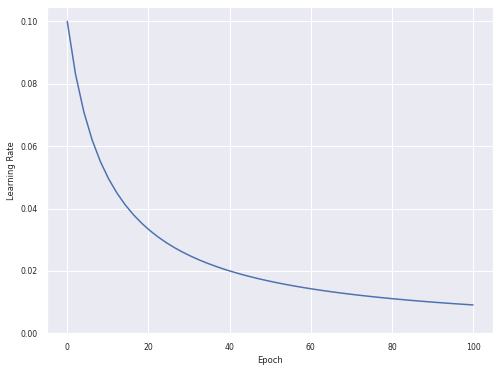

In [ ]:
#Gráfica del learning Rate con el paso de los epochs, convergue en el epoch 200 a 0.01 aprox.
step = np.linspace(0,100)
lr = lr_schedule(step)
plt.figure(figsize = (8,6))
plt.plot(step/1, lr)
plt.ylim([0,max(plt.ylim())])
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

In [ ]:
#Función para compilar y entrenar el conjunto de entrenamiento. Debido a la poca cantidad de datos, se escogió batch_size = len(X_train_s), por lo que los pasos de gradiente por epoch son 1.
#El único hiperparámetro que no se consideró hacer variar fue la función de pérdida, para ahorrar tiempo computacional, y porque para problemas de clasificación binaria /
#la recomendada por defecto es binary crossentropy.
def compile_and_fit(model, optimizer=None, max_epochs=200):
  if optimizer is None:
    optimizer = get_optimizer()

  model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.losses.BinaryCrossentropy( name='binary_crossentropy'), 'accuracy'])
  
  history = model.fit(X_train_s, y_train, steps_per_epoch = 1, validation_split=.3, epochs=max_epochs, shuffle=True, verbose = 0)
  return history

In [ ]:
#Modelo Red Neuronal Secuencial parametrizado, lo que permite ir probrando en ciclos for los distintos parámetros a considerar, y escoger la mejor combinación de éstos.
def normal_model_(nn = 30, layerss = 2, fa = 'elu', do = 0, l = [0.05,0.1], regularizador = regularizers.l1_l2 , inp = 22):
  
    
    normal_model = tf.keras.models.Sequential()
    for ly in range(layerss):
      if ly == 0:
        if regularizador != regularizers.l1_l2:
          h = layers.Dense(nn, activation=fa,input_shape=(inp,),kernel_regularizer=regularizador(l))
        else:
          h = layers.Dense(nn, activation=fa,input_shape=(inp,),kernel_regularizer=regularizador(l[0],l[1]))
      else:
        if regularizador != regularizers.l1_l2:
          h = layers.Dense(nn, activation=fa,kernel_regularizer=regularizador(l))
        else:
          h = layers.Dense(nn, activation=fa,kernel_regularizer=regularizador(l[0],l[1]))
        

      normal_model.add(h)
      normal_model.add(layers.Dropout(do))
    normal_model.add(layers.Dense(1, activation='sigmoid'))

    return normal_model

In [ ]:
#Visualización de la reducción de variables en el modelo, por tanto reducción en la complejidad de éste.
a = len(original_features)
b = len(new_features)
c = n # (n=5)
print('input shape original : {}'.format(a))
print('input shape al eliminar variables : {}'.format(b))
print('input shape después de PCA : {}'.format(c))

input shape original : 22
input shape al eliminar variables : 17
input shape después de PCA : 6


In [ ]:
#Función que prueba el Modelo Secuencial parametrizado para las distintas combinaciones de éstos, y los guarda en un DataFrame junto con toda su información respectivas, /
# y así poder comparar los modelos según la métrica adecuada, en este caso, la de mayor importancia : F1_score
#(Idealmente el objetivo de ésta función era correr todos los modelos posibles dentro de los rangos especificados (hiperparámetros), y para semillas distintas. Esto último no se logró,
# debido a complicaciones técnicas en la programación, ya que no logramos establecer las semillas que en teoría con tf.random.set_seed(j) pensamos que funcionarían).
def tuner_models(Trainingg ,FAA ,DOO ,LLL,RLLL,Capass,Neuronass,L1L22):
  
  i = 0
  for j in semillas:
    tf.random.set_seed(j)
    for get in OPT:
      for faa in FAA:
        for doo in DOO:
          for cap in Capass:
            for nn in Neuronass:
              for Rll in RLLL:
                if Rll != regularizers.l1_l2:
                  for ll in LLL:
                    #normal_model_(nn = 30, layerss = 2, fa = 'elu', do = 0, l = [0.05,0.1], regularizador = regularizers.l1_l2 , inp = 22):
                      normal_model_i = normal_model_(nn = nn, layerss = cap ,fa = faa, do = doo, l = ll , regularizador = Rll,inp = inp) #Crear modelo con combinaciones de hiperparámetros
                      _hist = compile_and_fit(normal_model_i, optimizer = get[0]) 
                      y_pred = predict(normal_model_i, X_test_s)
                      valores = [j,normal_model_i,nn,cap,_hist.history['val_accuracy'][-1],f1_score(y_test, y_pred, average = 'micro'),faa, Rll,ll,get[0],get[1],doo,_hist] 
                      Trainingg.iloc[i] = valores #Guardar modelo e hiperparámetros respectivos
                      Trainingg.iloc[[i]]
                      i = i + 1
                else:
                  for ll in L1L22:
                    normal_model_i = normal_model_(nn = nn, layerss = cap ,fa = faa, do = doo, l = ll , regularizador = Rll,inp = inp) #Crear modelo con combinaciones de hiperparámetros
                    _hist = compile_and_fit(normal_model_i, optimizer = get[0]) 
                    y_pred = predict(normal_model_i, X_test_s)
                    valores = [j,normal_model_i,nn,cap,_hist.history['val_accuracy'][-1],f1_score(y_test, y_pred, average = 'micro'),faa, Rll,ll,get[0],get[1],doo,_hist] 
                    Trainingg.iloc[i] = valores #Guardar modelo e hiperparámetros respectivos
                    Trainingg.iloc[[i]]
                    i = i + 1

In [ ]:
#Función utilizada para predecir utilizando el conjunto de testeo, estableciendo un threshold de 0.5 ( lo que habitualmente se hace para predecir en problemas de clasificación/
# binarios, dada la naturaleza de la función de activación sigmoide)
def predict(model, X):
  y_pred = pd.DataFrame(model.predict(X), columns = ['status'])
  y_pred = np.where(y_pred>0.5,1,0)    
  return y_pred

Tuning de los hiperparámetros

In [ ]:

inp = c                    #Este inp corresponde al número de componentes seleccionadas en el PCA, en este caso fueron 6.
semillas = [1]                #Idealmente acá iba un vector de semillas, sin embargo, por lo mencionado anteriormente (celda tuner_model), solo se consideró una.

#Learnings rates con penalización por epoch.
lr_01 = tf.keras.optimizers.schedules.InverseTimeDecay(0.1, decay_steps=1*10, decay_rate=1)
lr_001 = tf.keras.optimizers.schedules.InverseTimeDecay(0.01, decay_steps=1*10, decay_rate=1)
lr_0001 = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=1*10, decay_rate=1)

#Se modificaron levemente las funciones de los optimizadores, para mantener la consistencia de la programación en el ciclo for.
def get_optimizer(lr_schedulee, h):
  return tf.keras.optimizers.Adam(lr_schedulee),h

def get_optimizer2(lr_schedulee,h):
  return tf.keras.optimizers.RMSprop(lr_schedulee),h


#Hiperparámetros para probar distintos modelos

FA = ['relu']                                             #Fun                                                       Funciones de activación
DO =[0,0.1]                    #[0,0.5]                   #parámetro para dropout                                    Parámetros Dropout
LL =[0,0.01,0.001]                                        #[0.1,0.05,0.01,0] #parámetro para l1 o l2                 Parámetros de L1 o L2
L1L2 = [[0.1,0.1]]                                        #parámetros para l1_l2                                     Parámetros para L1_L2
Neuronas = [32,64,120]                                    #[1,4,16,32,64,260,512]                                    Número neuronas por capa
Capas = [2,4]                                             #                                                          Número capas
RLL = [regularizers.l2]#,regularizers.l1]#,regularizers.l1_l2]                                                       Regularizadores
OPT = [get_optimizer(lr_0001,0.001),get_optimizer(lr_001,0.01)]#,get_optimizer2()]                                   Optimizadores
N_models = len(FA) * len(DO) * len(LL) * len(Neuronas) * len(Capas) * len(RLL) * len(semillas) * len(OPT) * len(L1L2)# Modelos a probar
print(N_models)

#DataFrame que contendrá cada modelo con su respectiva combinación de parámetros
valores = ['Semilla','Modelo','Neuronas','Capas', 'Accuracy_val', 'F1_score','Fa','Rl','Param Rl','Opt','Lr','Dropout','Hist']# 'Param Opt' ]
Training = pd.DataFrame(columns=valores,
                  index=range(N_models))

tuner_models(Trainingg = Training,FAA = FA ,DOO = DO,LLL= LL,RLLL=RLL,Capass=Capas,Neuronass=Neuronas,L1L22 = L1L2)
Training

72


,Semilla,Modelo,Neuronas,Capas,Accuracy_val,F1_score,Fa,Rl,Param Rl,Opt,Lr,Dropout,Hist
0,1,<tensorflow.python.keras.engine.sequential.Seq...,32,2,0.826087,0.8,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.001,0,<tensorflow.python.keras.callbacks.History obj...
1,1,<tensorflow.python.keras.engine.sequential.Seq...,32,2,0.869565,0.75,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.001,0,<tensorflow.python.keras.callbacks.History obj...
2,1,<tensorflow.python.keras.engine.sequential.Seq...,32,2,0.434783,0.6,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.001,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.001,0,<tensorflow.python.keras.callbacks.History obj...
3,1,<tensorflow.python.keras.engine.sequential.Seq...,64,2,0.565217,0.85,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.001,0,<tensorflow.python.keras.callbacks.History obj...
4,1,<tensorflow.python.keras.engine.sequential.Seq...,64,2,0.478261,0.65,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.001,0,<tensorflow.python.keras.callbacks.History obj...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,1,<tensorflow.python.keras.engine.sequential.Seq...,64,4,0.695652,0.8,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
68,1,<tensorflow.python.keras.engine.sequential.Seq...,64,4,0.826087,0.95,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.001,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
69,1,<tensorflow.python.keras.engine.sequential.Seq...,120,4,0.73913,0.75,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
70,1,<tensorflow.python.keras.engine.sequential.Seq...,120,4,0.956522,0.85,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...


Top 10 mejores modelos (En base a F1_score )

In [ ]:
#Del Dataframe Training que contiene todos los modelos entrenados con distintas combinaciones de hiperparámetros, se obtiene el Ranking de los modelos según/
#el F1_score obtenido en cada uno.
Ranking = Training.sort_values(['F1_score'], ascending=False).iloc[:10,:]
Ranking = Ranking.reset_index()
Ranking.head(10)

,index,Semilla,Modelo,Neuronas,Capas,Accuracy_val,F1_score,Fa,Rl,Param Rl,Opt,Lr,Dropout,Hist
0,8,1,<tensorflow.python.keras.engine.sequential.Seq...,120,2,0.869565,1,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.001,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.001,0,<tensorflow.python.keras.callbacks.History obj...
1,68,1,<tensorflow.python.keras.engine.sequential.Seq...,64,4,0.826087,0.95,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.001,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
2,62,1,<tensorflow.python.keras.engine.sequential.Seq...,120,2,0.826087,0.95,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.001,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
3,71,1,<tensorflow.python.keras.engine.sequential.Seq...,120,4,0.913043,0.9,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.001,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
4,45,1,<tensorflow.python.keras.engine.sequential.Seq...,32,4,0.869565,0.9,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0,<tensorflow.python.keras.callbacks.History obj...
5,46,1,<tensorflow.python.keras.engine.sequential.Seq...,32,4,0.782609,0.9,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0,<tensorflow.python.keras.callbacks.History obj...
6,61,1,<tensorflow.python.keras.engine.sequential.Seq...,120,2,0.782609,0.9,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
7,58,1,<tensorflow.python.keras.engine.sequential.Seq...,64,2,0.869565,0.9,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
8,66,1,<tensorflow.python.keras.engine.sequential.Seq...,64,4,0.73913,0.85,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0.1,<tensorflow.python.keras.callbacks.History obj...
9,52,1,<tensorflow.python.keras.engine.sequential.Seq...,120,4,0.869565,0.85,relu,<class 'tensorflow.python.keras.regularizers.L2'>,0.01,<tensorflow.python.keras.optimizer_v2.adam.Ada...,0.01,0,<tensorflow.python.keras.callbacks.History obj...


In [ ]:
#Selección de los mejores modelos para graficarlos y comparar
size_histories = {}
n1 , n2, n3 = 0, 1 ,2

size_histories['N°1'] = Ranking.iloc[n1]
size_histories['N°2'] = Ranking.iloc[n2]
size_histories['N°3'] = Ranking.iloc[n3]
size_histories


{'N°1': index                                                           8
 Semilla                                                         1
 Modelo          <tensorflow.python.keras.engine.sequential.Seq...
 Neuronas                                                      120
 Capas                                                           2
 Accuracy_val                                             0.869565
 F1_score                                                        1
 Fa                                                           relu
 Rl              <class 'tensorflow.python.keras.regularizers.L2'>
 Param Rl                                                    0.001
 Opt             <tensorflow.python.keras.optimizer_v2.adam.Ada...
 Lr                                                          0.001
 Dropout                                                         0
 Hist            <tensorflow.python.keras.callbacks.History obj...
 Name: 0, dtype: object,
 'N°2': index                 

In [ ]:
#F1_SCORE de los modelos escogidos (sirve para corroborar porque ya se habían calculado previamente)
def predict(model, X):
  y_pred = pd.DataFrame(model.predict(X), columns = ['status'])
  y_pred = np.where(y_pred>0.5,1,0)    
  return y_pred
models = []
for val in size_histories:
  models.append(size_histories[val]['Modelo'])
for i,model in enumerate(models):
  print('N°',i,': ',f1_score(y_test, predict(model, X_test_s), average = 'micro'))

N° 0 :  1.0
N° 1 :  0.9500000000000001
N° 2 :  0.9500000000000001


In [ ]:
# Funcion personalizada para graficar la evolucion del entrenamiento
def train_results(train_loss, val_loss, train_acc, val_acc, mod):
  fig, axs = plt.subplots(nrows = 1, ncols = 2, figsize = ((14, 2)))
  ax = axs[0]
  ax.set_title('Val Loss: {} (Nn :{} ,Capas: {})'.format(round(mod['Hist'].history['val_loss'][-1],3),mod['Neuronas'],mod['Capas']), fontsize = 15)
  
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  ax.plot(train_loss, label = 'loss_train', color = 'black', linestyle = '-')
  ax.plot(val_loss, label = 'loss_val', color = 'orange')
  ax.set_xlabel('Epochs', fontsize = 13)
  ax.legend()

  ax = axs[1]
  ax.set_title('(F1_score: {} )Val Accuracy: {}'.format(mod['F1_score'],round(mod['Hist'].history['val_accuracy'][-1],3)), fontsize = 15)
  ax.grid(color = 'black', alpha = 0.5, linestyle = 'dashed', linewidth = 0.5)
  ax.plot(train_acc, label = 'acc_train', color = 'black', linestyle = '-')
  ax.plot(val_acc, label = 'acc_val', color = 'orange')
  ax.set_xlabel('Epochs', fontsize = 13)
  plt.legend()

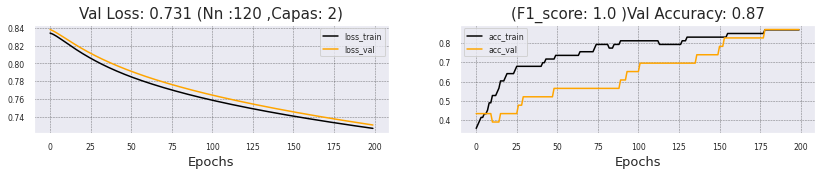

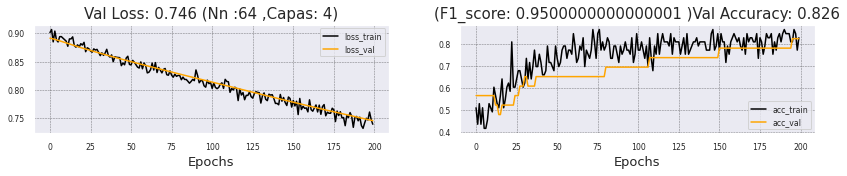

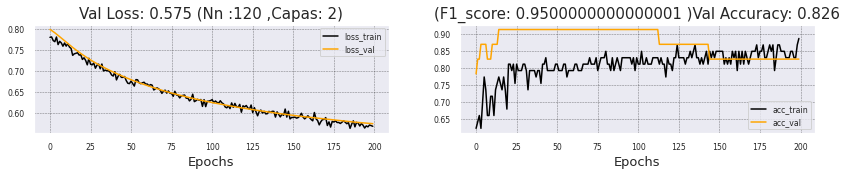

In [ ]:
for i,val in enumerate(size_histories):
  train_results(size_histories[val]['Hist'].history['loss'], size_histories[val]['Hist'].history['val_loss'], size_histories[val]['Hist'].history['accuracy'], size_histories[val]['Hist'].history['val_accuracy'],size_histories[val])

In [ ]:
#Matriz de confusión

from sklearn.metrics import confusion_matrix, plot_confusion_matrix, f1_score
conf_mat = [[0,0],[0,0],[0,0]]
for i,model in enumerate(models):
  y_pred = predict(model,X_test_s)
  conf_mat[i][0] = confusion_matrix(y_test, y_pred)
  conf_mat[i][1] = conf_mat[i][0] / np.sum(conf_mat[i][0], axis = 1)
  print(conf_mat[i][0])

[[10  0]
 [ 0 10]]
[[10  0]
 [ 1  9]]
[[ 9  1]
 [ 0 10]]


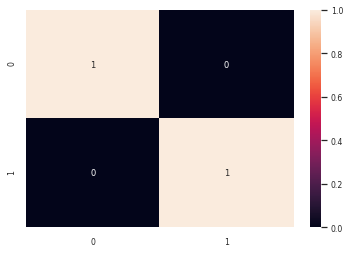

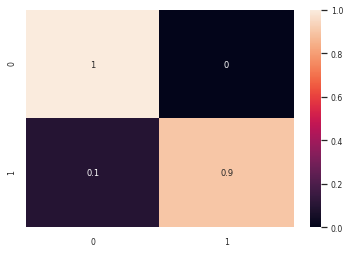

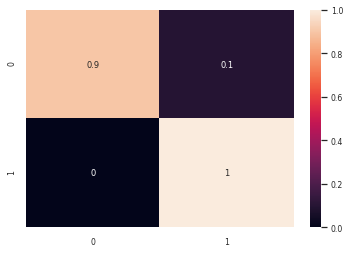

In [ ]:
# Podemos usar seaborn para graficar esta matriz
for conf in conf_mat:
  sns.heatmap(conf[1], annot = True)
  plt.show()
  


In [ ]:
for g in ['N°1','N°2','N°3']:
  print(g,': ',size_histories[g]['Hist'].history['val_accuracy'][-1])



N°1 :  0.8695651888847351
N°2 :  0.8260869383811951
N°3 :  0.8260869383811951


Selección del posible mejor Modelo

In [ ]:
#Seleccionamos el mejor modelo, y lo guardamos... 
options = ['N°1','N°2','N°3']
Best = size_histories['N°1']
Best_model = Best['Modelo']
Best

index                                                           8
Semilla                                                         1
Modelo          <tensorflow.python.keras.engine.sequential.Seq...
Neuronas                                                      120
Capas                                                           2
Accuracy_val                                             0.869565
F1_score                                                        1
Fa                                                           relu
Rl              <class 'tensorflow.python.keras.regularizers.L2'>
Param Rl                                                    0.001
Opt             <tensorflow.python.keras.optimizer_v2.adam.Ada...
Lr                                                          0.001
Dropout                                                         0
Hist            <tensorflow.python.keras.callbacks.History obj...
Name: 0, dtype: object

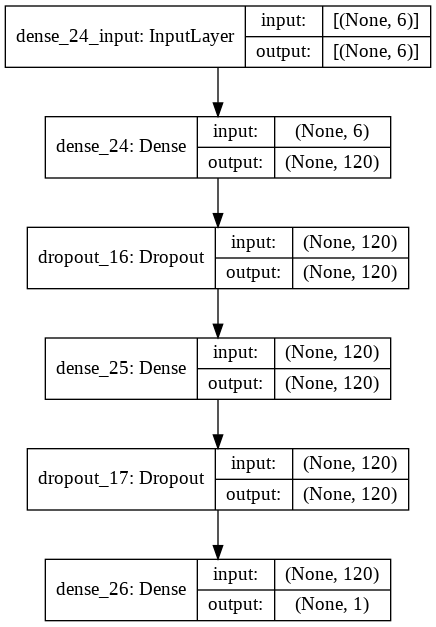

In [ ]:
path = '/content/drive/MyDrive/Ayudantia 2/figs/LRtf.png'
# Exportamos un diagrama
tf.keras.utils.plot_model(Best_model, path, show_shapes=True)

Ejecución del posible mejor modelo para obtener finalmente el mejor modelo ( se redujo el espacio de búsqueda con el Ranking utilizado, por lo que en esta etapa se puede ir probando de forma más específica)

In [ ]:
#En esta etapa, es posible probar el o los mejores modelos, y probar uno por uno hasta encontrar el que pueda considerarse el mejor modelo.
#Esto en base a un equilibrio entre F1_score y Accuracy_val

#Entrenar el modelo escogido
inp = c                       #Este inp corresponde al número de componentes seleccionadas en el PCA, en este caso fueron 6.
semillas = [1]                #Idealmente acá iba un vector de semillas, sin embargo, por lo mencionado anteriormente (celda tuner_model), solo se consideró una.

#Learnings rates con penalización por epoch.
lr_01 = tf.keras.optimizers.schedules.InverseTimeDecay(0.1, decay_steps=1*10, decay_rate=1)
lr_001 = tf.keras.optimizers.schedules.InverseTimeDecay(0.01, decay_steps=1*10, decay_rate=1)
lr_0001 = tf.keras.optimizers.schedules.InverseTimeDecay(0.001, decay_steps=1*10, decay_rate=1)

#Se modificaron levemente las funciones de los optimizadores, para mantener la consistencia de la programación en el ciclo for.
def get_optimizer(lr_schedulee, h):
  return tf.keras.optimizers.Adam(lr_schedulee),h

def get_optimizer2(lr_schedulee,h):
  return tf.keras.optimizers.RMSprop(lr_schedulee),h

Best = size_histories['N°1']
print(Best)
#Hiperparámetros para probar distintos modelos
['Semilla','Modelo','Neuronas','Capas', 'Accuracy_val', 'F1_score','Fa','Rl','Param Rl','Opt','Lr','Dropout','Hist']
faa = 'relu'                                  
doo = 0        
ll =0.01                                     
L1L2 = [[0.1,0.1]]                               
nnn = 120                         
cap = 2
Rll = regularizers.l2
opt = get_optimizer(lr_0001,0.001)

#DataFrame que contendrá cada modelo con su respectiva combinación de parámetros
#valores = ['Semilla','Modelo','Neuronas','Capas', 'Accuracy_val', 'F1_score','Fa','Rl','Param Rl','Opt','Lr','Dropout','Hist']# 'Param Opt' ]
valoresss = ['Semilla','Modelo','Neuronas','Capas', 'Accuracy_val', 'F1_score','Fa','Rl','Param Rl','Opt','Lr','Dropout','Hist']# 'Param Opt' ]
T = pd.DataFrame(columns=valoresss,
                  index=range(1))
Training_model = normal_model_(nn = nnn, layerss = cap, fa = faa, do = doo, l = ll, regularizador = Rll , inp = c)
hist_t = compile_and_fit(Training_model,opt[0])
y_pred_t = predict(Training_model, X_test_s)
valoress = [0,Training_model,nnn,cap,hist_t.history['val_accuracy'][-1],f1_score(y_test, y_pred_t),faa, Rll,ll,opt[0],opt[1],doo,hist_t] 
T.iloc[0] = valoress #Guardar modelo e hiperparámetros respectivos

index                                                           8
Semilla                                                         1
Modelo          <tensorflow.python.keras.engine.sequential.Seq...
Neuronas                                                      120
Capas                                                           2
Accuracy_val                                             0.869565
F1_score                                                        1
Fa                                                           relu
Rl              <class 'tensorflow.python.keras.regularizers.L2'>
Param Rl                                                    0.001
Opt             <tensorflow.python.keras.optimizer_v2.adam.Ada...
Lr                                                          0.001
Dropout                                                         0
Hist            <tensorflow.python.keras.callbacks.History obj...
Name: 0, dtype: object


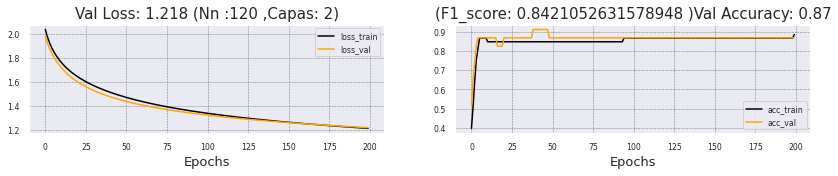

In [ ]:
size_histories_t = {}
size_histories_t['N°1°'] = T.iloc[0] 
for i,val in enumerate(size_histories_t):
  train_results(size_histories_t[val]['Hist'].history['loss'], size_histories_t[val]['Hist'].history['val_loss'], size_histories_t[val]['Hist'].history['accuracy'], size_histories_t[val]['Hist'].history['val_accuracy'],size_histories_t[val])

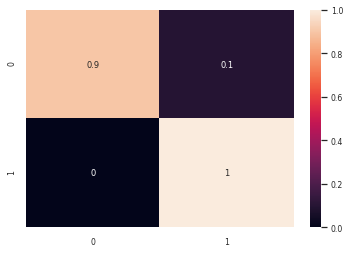

In [ ]:
conf_mat = [0,0]
conf_mat[0] = confusion_matrix(y_test, y_pred_t)
conf_mat[1] = conf_mat[0] / np.sum(conf_mat[0], axis = 1)
# Podemos usar seaborn para graficar esta matriz
sns.heatmap(conf[1], annot = True)
plt.show()
  

In [ ]:
T.iloc[0]

Semilla                                                         0
Modelo          <tensorflow.python.keras.engine.sequential.Seq...
Neuronas                                                      120
Capas                                                           2
Accuracy_val                                             0.869565
F1_score                                                 0.842105
Fa                                                           relu
Rl              <class 'tensorflow.python.keras.regularizers.L2'>
Param Rl                                                     0.01
Opt             <tensorflow.python.keras.optimizer_v2.adam.Ada...
Lr                                                          0.001
Dropout                                                         0
Hist            <tensorflow.python.keras.callbacks.History obj...
Name: 0, dtype: object

Guardamos el o los modelos que consideremos pertinentes...

In [ ]:
path = 'Final'
Best_best_model = T.iloc[0]['Modelo']
#Best_best_model.predict(X_test_s)
Best_best_model.save_weights(path, save_format='tf')

In [ ]:
#Mejor modelo actual
#Semilla                                                         0
#Modelo          <tensorflow.python.keras.engine.sequential.Seq...
#Neuronas                                                      120
#Capas                                                           2
#Accuracy_val                                             0.869565
#F1_score                                                 0.842105
#Fa                                                           relu
#Rl              <class 'tensorflow.python.keras.regularizers.L2'>
#Param Rl                                                     0.01
#Opt             <tensorflow.python.keras.optimizer_v2.adam.Ada...
#Lr                                                          0.001
#Dropout                                                         0
#Hist            <tensorflow.python.keras.callbacks.History obj...
#Name: 0, dtype: object

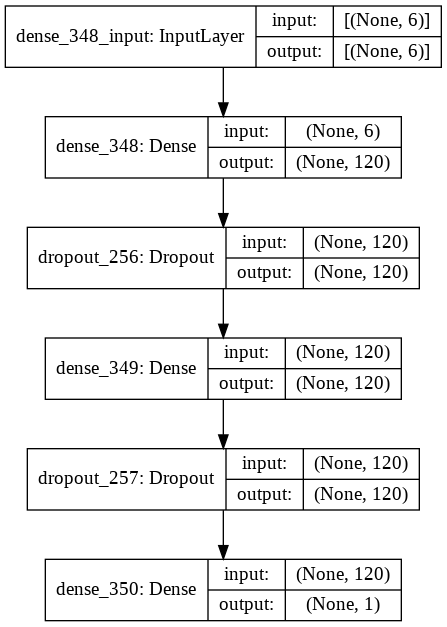

In [ ]:
path = '/content/drive/MyDrive/Ayudantia 2/figs/LRtf.png'
# Exportamos un diagrama
tf.keras.utils.plot_model(Best_best_model, path, show_shapes=True)